Importing libraries and setting parameters


In [12]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import EfficientNetB0
from keras.models import Sequential
from keras import layers
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Dataset paths
BASE_DIR = '/content/drive/My Drive/fast_campus_augmented_new'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
VALID_DIR = os.path.join(BASE_DIR, 'valid')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20

Preprocessing and Augmentation

In [13]:
# Data Augmentation and Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=20,
    brightness_range=[0.8, 1.2]
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 3475 images belonging to 7 classes.
Found 42 images belonging to 7 classes.
Found 33 images belonging to 7 classes.


Builiding Model

In [14]:
from tensorflow.keras.applications import Xception

# Build the Model
xception_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

model = Sequential([
    xception_base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(7, activation='softmax')  # Adjust for your number of classes
])

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 7, 7, 2048)          │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │          14,343 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,875,823 (79.63 MB)

 Trainable params: 20,821,295 (79.43 MB)

 Non-trainable params: 54,528 (213.00 KB)

Training Model

In [15]:
# Model Checkpoint
checkpoint = ModelCheckpoint(
    'best_xception_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Train the Model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 822ms/step - accuracy: 0.5792 - auc: 0.8466 - loss: 1.2887 - precision: 0.8587 - recall: 0.2549
Epoch 1: val_loss improved from inf to 0.54900, saving model to best_xception_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 138s 901ms/step - accuracy: 0.5812 - auc: 0.8477 - loss: 1.2837 - precision: 0.8599 - recall: 0.2578 - val_accuracy: 0.8571 - val_auc: 0.9746 - val_loss: 0.5490 - val_precision: 0.8750 - val_recall: 0.8333
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 679ms/step - accuracy: 0.9905 - auc: 0.9999 - loss: 0.0574 - precision: 0.9939 - recall: 0.9844
Epoch 2: val_loss improved from 0.54900 to 0.34324, saving model to best_xception_model.keras
109/109 ━━━━━━━━━━━━━━━━━━━━ 77s 698ms/step - accuracy: 0.9905 - auc: 0.9999 - loss: 0.0573 - precision: 0.9939 - recall: 0.9844 - val_accuracy: 0.9286 - val_auc: 0.9814 - val_loss: 0.3432 - val_precision: 0.9268 - val_recall: 0.9048
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 680ms/step - accuracy: 0.9

plotting curves

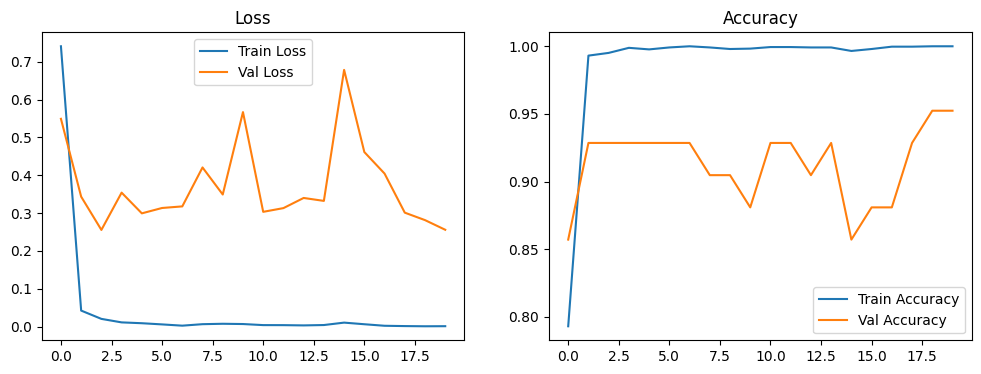

In [16]:
# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

Evaluating on Test data

In [17]:
# Evaluate the Model
model.load_weights('best_xception_model.keras')

test_loss, test_accuracy, test_precision, test_recall, test_auc = model.evaluate(test_generator)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9081 - auc: 0.9948 - loss: 0.3612 - precision: 0.9081 - recall: 0.9081
Test Loss: 0.3575
Test Accuracy: 0.9091
Test Precision: 0.9091
Test Recall: 0.9091
Test AUC: 0.9949


Classification report and Confusion matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step

Classification Report:
              precision    recall  f1-score   support

     A Block       1.00      0.71      0.83         7
     B Block       1.00      1.00      1.00         3
     C Block       1.00      1.00      1.00         1
     D Block       0.75      1.00      0.86         6
     E Block       0.75      1.00      0.86         3
     F Block       1.00      0.75      0.86         4
 IEEE Office       1.00      1.00      1.00         9

    accuracy                           0.91        33
   macro avg       0.93      0.92      0.91        33
weighted avg       0.93      0.91      0.91        33


Confusion Matrix:
[[5 0 0 1 1 0 0]
 [0 3 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 6 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 1 0 3 0]
 [0 0 0 0 0 0 9]]


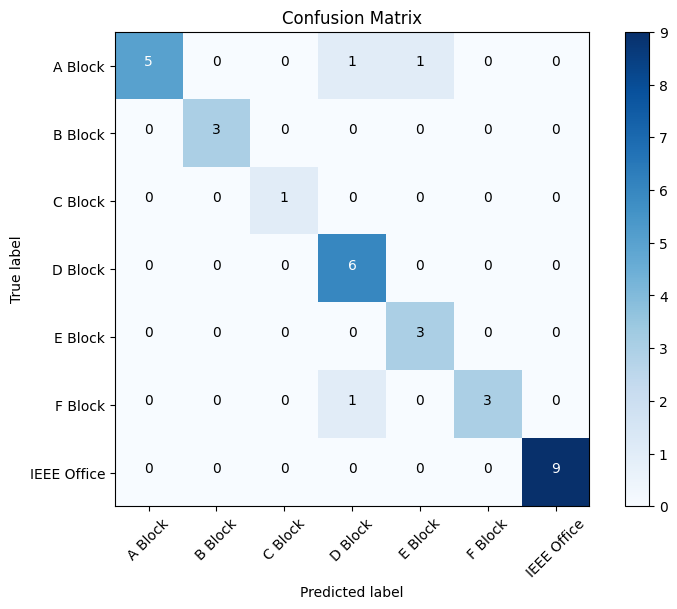

In [18]:
# Generate Classification Report
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(test_generator.class_indices))
plt.xticks(tick_marks, test_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, test_generator.class_indices.keys())

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if conf_matrix[i, j] > conf_matrix.max() / 2. else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Saving Model

In [19]:
# Save the Model
SAVE_DIR = os.path.join(BASE_DIR, 'saved_models')
os.makedirs(SAVE_DIR, exist_ok=True)

model_path = os.path.join(SAVE_DIR, 'xception_model_2.h5')
model.save(model_path)

print(f"Model saved to {model_path}")

Model saved to /content/drive/My Drive/fast_campus_augmented_new/saved_models/xception_model_2.h5
